## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [52]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "無"

In [53]:
train, test = keras.datasets.cifar10.load_data()

In [54]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [55]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [56]:
from keras.regularizers import l2

def build_mlp(input_shape, output_units=10, num_neurons=[256,512], l2_ratio=1e-3, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
        x = keras.layers.Dropout(drp_ratio)(x)
        x = keras.layers.BatchNormalization()(x)    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [57]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95
BATCH_SIZE = [256,512]


In [58]:
results = {}
"""
使用迴圈建立



L2 的模型並訓練
"""
for batch_size in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag ="batch_size-%s"  % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

50000/50000 [==============================] - 7s 131us/step - loss: 1.3064 - acc: 0.6847 - val_loss: 1.7016 - val_acc: 0.5621
Epoch 49/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.2874 - acc: 0.6891 - val_loss: 1.6953 - val_acc: 0.5581
Epoch 50/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.2849 - acc: 0.6895 - val_loss: 1.6942 - val_acc: 0.5559
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_

Epoch 46/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6387 - acc: 0.6226 - val_loss: 1.8312 - val_acc: 0.5514
Epoch 47/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.6229 - acc: 0.6296 - val_loss: 1.8280 - val_acc: 0.5555
Epoch 48/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.6144 - acc: 0.6299 - val_loss: 1.8292 - val_acc: 0.5552
Epoch 49/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.6017 - acc: 0.6322 - val_loss: 1.8217 - val_acc: 0.5534
Epoch 50/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.5915 - acc: 0.6335 - val_loss: 1.8189 - val_acc: 0.5555


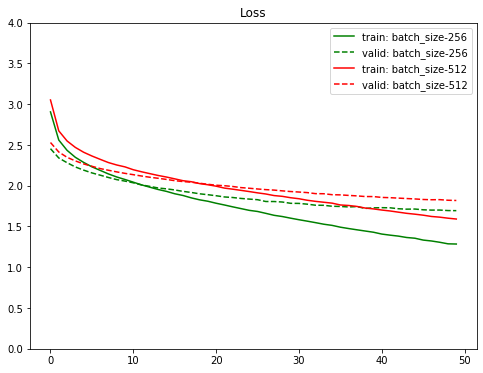

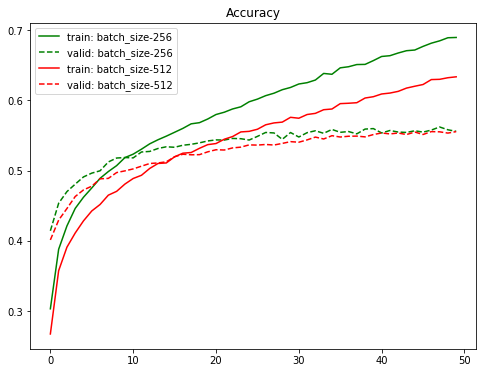

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = [ "g","r"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 4])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()